In [1]:
"""DenseNet models for Keras.
# Reference paper
- [Densely Connected Convolutional Networks]
  (https://arxiv.org/abs/1608.06993) (CVPR 2017 Best Paper Award)
# Reference implementation
- [Torch DenseNets]
  (https://github.com/liuzhuang13/DenseNet/blob/master/models/densenet.lua)
- [TensorNets]
  (https://github.com/taehoonlee/tensornets/blob/master/tensornets/densenets.py)
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

### setting the different directories 

# on the server (linux):
# where to find the images:
#home_dir = '/home/rick/Documents/HannahZ'
# folder where to save code and so on
#code_dir = home_dir + '/Code'
# where to save the final models
#model_dir = code_dir + '/Final_models'
# where to save the logs for visualization in TensorBoard
#log_dir = code_dir + '/logs'
# where to save the weights
#new_weight_dir = code_dir + '/new_weights'

modelname = 'DenseNet121'

# on my computer (windows):
# where to find the images:
home_dir = '\\Users\\ThinkPad User\\Google Drive\\DeepSolaris'
# folder where to save code and so on
code_dir = '\\Users\\ThinkPad User\\Google Drive\\Master_thesis_H_Z_DL&NN\\Coding'
# where to save the final models
model_dir = code_dir + '\\Final_models_saved'
# where to save the logs for visualization in TensorBoard
log_dir = code_dir + '\\logs'
import os
os.chdir(home_dir)

In [2]:
from keras import backend as K
from keras.models import Model
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.utils.data_utils import get_file
from keras.engine import get_source_inputs
from keras.applications import imagenet_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape 

from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.losses import binary_crossentropy


from random import randrange
from random import seed
from random import sample
import tensorflow as tf


import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from datetime import timedelta
import math
from sklearn.model_selection import train_test_split
from datetime import datetime
from keras.preprocessing import image
from keras.optimizers import SGD
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import keras
from keras.callbacks import Callback

Using TensorFlow backend.


In [3]:
os.chdir(code_dir)
import DenseNet_pretrained
from DenseNet_pretrained import DenseNet
from DenseNet_pretrained import conv_block
from DenseNet_pretrained import transition_block
from DenseNet_pretrained import dense_block
from DenseNet_pretrained import DenseNet121

In [4]:
seed(0)
### Helper metrics functions

# def accuracy(y_true, y_pred):
#     accuracy = K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)
#     return accuracy
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
    
    
def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=1)

In [5]:
no_of_epochs = 0

### check if data are in the right format
K.image_data_format() == 'channels_last'

os.chdir(home_dir)
train_images = np.load('training_images_AcMüDüHo.npy')
valid_images = np.load('validation_images_AcMüDüHo.npy')
test_images = np.load('test_images_AcMüDüHo.npy')
train_labels = np.load('training_labels_AcMüDüHo.npy')
valid_labels = np.load('validation_labels_AcMüDüHo.npy')
test_labels = np.load('test_labels_AcMüDüHo.npy')

print("Size of:")
print("- Training-set:\t\t{}".format(len(train_labels)))
print("- Validation-set:\t{}".format(len(valid_labels)))
print("- Test-set:\t\t{}".format(len(test_labels)))

Size of:
- Training-set:		3357
- Validation-set:	374
- Test-set:		934


In [6]:
## test-settings for no-gpu-case
# test_size = 100
# valid_size = int(0.1 * test_size)
# train_images = train_images[:test_size,:,:,:]
# valid_images = valid_images[:valid_size,:,:,:]
# test_images = test_images[:valid_size,:,:,:]
# train_labels = train_labels[:test_size]
# valid_labels = valid_labels[:valid_size]
# test_labels = test_labels[:valid_size]

# print("Size of:")
# print("- Training-set:\t\t{}".format(len(train_labels)))
# print("- Validation-set:\t{}".format(len(valid_labels)))
# print("- Test-set:\t\t{}".format(len(test_labels)))


In [7]:
### Callbacks used
# EarlStop = EarlyStopping(monitor='val_loss',
#                              min_delta=0,
#                             patience=20,
#                            verbose=0, mode='auto')

In [8]:
os.chdir(code_dir)
from Learning_rate_scheduler import LrReducer
from CyclicLR import CyclicLR

In [9]:
# choose training specifications
weights = 'imagenet' 
# otherwise weights = None
trainable_layers = 'Frozen'
# otherwise trainable_layers = x

In [ ]:
# importing the currently used model
import keras

### create the base pre-trained model
Model_base = keras.applications.xception.Xception(weights = 'imagenet', include_top=False)

In [13]:
# choose trainable layers as 'Frozen' or 'All' or some number
trainable_layers = 'Frozen'
# otherwise trainable_layers = x
# add a global spatial average pooling layer to the pretrained model to 
# finish its compilation
def compileModel(trainable_layers = 'Frozen'):
    global Final_model
    x = Model_base.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)
    Final_model = Model(inputs=Model_base.input, outputs=preds)
    if (trainable_layers == 'Frozen'):
        for layer in Model_base.layers:   # only train the new layers first
            layer.trainable = False
    elif (trainable_layers == 'All'):
        for layer in Model_base.layers:   # only train the new layers first
            layer.trainable = True
    else:
        for layer in Model_base.layers[:trainable_layers]:
            layer.trainable = False
        for layer in Model_base.layers[trainable_layers:]:  
            layer.trainable = True
    Final_model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                            metrics=['accuracy', precision, recall, fmeasure])

In [ ]:
# choose trainable layers as 'Frozen' or 'All' or some number
trainable_layers = 'Frozen'
# otherwise trainable_layers = x
# add a global spatial average pooling layer to the pretrained model to 
# finish its compilation
def compileModel(trainable_layers = 'Frozen'):
    global Final_model
    x = Model_base.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)
    Final_model = Model(inputs=Model_base.input, outputs=preds)
    if (trainable_layers == 'Frozen'):
        for layer in Model_base.layers:   # only train the new layers first
            layer.trainable = False
    elif (trainable_layers == 'All'):
        for layer in Model_base.layers:   # only train the new layers first
            layer.trainable = True
    else:
        for layer in Model_base.layers[:trainable_layers]:
            layer.trainable = False
        for layer in Model_base.layers[trainable_layers:]:  
            layer.trainable = True
    Final_model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                            metrics=['accuracy', precision, recall, fmeasure])

In [14]:
###################### first training stage ###################################
def train_Model(verbose =1, times = 2, epochs = 100, base_lr = 0.00001, max_lr=0.001, mode = 'triangular', 
                stepsize = 157, batch_size = 64, use_tensorboard = False, use_checkp = False):
    start_time = time()   
    global h
    global no_of_epochs
    global name
    global filepath
    date = str(datetime.now().date())
    # logdir in linux:
    logdir = (log_dir + '/' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + '_base-' 
              + str(base_lr) + '_max-' + str(max_lr) + '_' + str(times))
    # logdir in windows:
    ##logdir = (log_dir + '\\' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + 
    #          '_base-' + str(base_lr) + '_max-' + str(max_lr) + '_' + str(times))
    name = ('batch size: ' + str(batch_size) + ', mode: ' + str(mode) + ', stepsize: ' 
            + str(stepsize) + ', base-lr: ' + str(base_lr) + ', max-lr ' + str(max_lr) + ', *' + str(times))
    print(' - Model specifics:\t{}'.format(name))
    clr = CyclicLR(base_lr = base_lr, max_lr=max_lr,
                        step_size= stepsize, mode = mode)
    fp = ('bs-' + str(batch_size) + '_' + str(mode) + '_sz-' + str(stepsize) + '_blr-' + str(base_lr) + '_mlr-' 
        + str(max_lr)) + '_' + weights + '_' + trainable_layers
    filepath = model_dir + '/' + fp + '.hdf5'
    checkp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_weights_only=True, 
                            save_best_only=True, mode='max', period=1)
    tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, 
                         write_graph=False, write_images=False)
    if (use_checkp == True):
        Final_model.fit(x = train_images, y = train_labels, epochs = epochs, callbacks= [tbCallBack, clr, checkp], 
                        validation_data = (valid_images, valid_labels), batch_size = batch_size,verbose = verbose)
    else:
        if (use_tensorboard == True):
            Final_model.fit(x = train_images, y = train_labels, epochs = epochs, callbacks= [tbCallBack, clr], 
                            validation_data = (valid_images, valid_labels), batch_size = batch_size, 
                            verbose = verbose)
        else:
            Final_model.fit(x = train_images, y = train_labels, epochs = epochs, callbacks= [clr], 
                            validation_data = (valid_images, valid_labels), batch_size = batch_size, 
                            verbose = verbose)
    no_of_epochs = no_of_epochs + epochs
    h = []
    h = clr.history
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')

In [108]:
h = []
compileModel()
train_Model(times = 1, epochs = 2, use_tensorboard = True)
train_acc = round(Final_model.evaluate(train_images, train_labels, 128)[1],4)
valid_acc = round(Final_model.evaluate(valid_images, valid_labels, 128)[1],4)
test_acc = round(Final_model.evaluate(test_images, test_labels, 128)[1],4)

print("- Training accuracy:\t{}".format(train_acc))
print("- Validation accuracy:\t{}".format(valid_acc))
print("- Test accuracy:\t{}".format(test_acc))

 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.001, *1
Train on 3357 samples, validate on 374 samples
Epoch 1/2
 320/3357 [=>............................] - ETA: 26s - loss: 0.8042 - acc: 0.5344 - precision: 0.5247 - recall: 0.4607 - fmeasure: 0.4876

/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.155287). Check your callbacks.
  % delta_t_median)


3357/3357 [==============================] - 7s 2ms/step - loss: 0.5799 - acc: 0.7015 - precision: 0.6977 - recall: 0.7148 - fmeasure: 0.6999 - val_loss: 0.9096 - val_acc: 0.7460 - val_precision: 0.6674 - val_recall: 0.9558 - val_fmeasure: 0.7853
Epoch 2/2
3357/3357 [==============================] - 3s 953us/step - loss: 0.3731 - acc: 0.8362 - precision: 0.8398 - recall: 0.8414 - fmeasure: 0.8354 - val_loss: 0.5774 - val_acc: 0.8021 - val_precision: 0.7623 - val_recall: 0.8537 - val_fmeasure: 0.8052
Time usage: 0:00:16 minutes
934/934 [==============================] - 1s 901us/step
- Training accuracy:	0.8183
- Validation accuracy:	0.8021
- Test accuracy:	0.7816


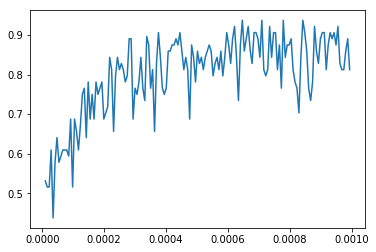

In [45]:
stepsize = 157
len(h)
%matplotlib inline
lr = h['lr'][:stepsize]
acc = h['acc'][:stepsize]
plt.plot(lr, acc)

In [82]:
### choose your learning rates now! The one where the accuracy starts to rise as base_lr and the one where it stops
### growing/ starts to tumble as max_lr

In [169]:
# experiment with different learning rate ranges
def learning_rate_finder(rep = 5, epochs = 50):
    start_time = time() 
    global test_acc_list
    global valid_acc_list
    global train_acc_list
    global test_loss_list
    global valid_loss_list
    global train_loss_list
    global test_prec_list
    global valid_prec_list
    global train_prec_list
    global test_rec_list
    global valid_rec_list
    global train_rec_list
    global model_details
    model_details = []
    test_acc_list = []
    valid_acc_list = []
    train_acc_list = []
    test_loss_list = []
    valid_loss_list = []
    train_loss_list = []
    test_prec_list = []
    valid_prec_list = []
    train_prec_list = []
    test_rec_list = []
    valid_rec_list = []
    train_rec_list = []
    for blr in [0.00001, 0.00005, 0.0001]:
        print('NEXT LEARNINGRATE: {}'.format(blr))
        for mlr in [0.0003, 0.0006, 0.0009]:
            print('Models with base lr = ' + str(blr) + ' and max lr = ' + str(mlr))
            for i in range(rep):
                    compileModel()
                    times = i
                    if (i == 0):
                        train_Model(times = times, epochs = epochs, base_lr = blr, max_lr = mlr, verbose = 0, 
                                    use_tensorboard = True)
                    else:
                        train_Model(times = times, epochs = epochs, base_lr = blr, max_lr = mlr, verbose = 0)
                    train_metrics = Final_model.evaluate(train_images, train_labels)
                    valid_metrics = Final_model.evaluate(valid_images, valid_labels)
                    test_metrics = Final_model.evaluate(test_images, test_labels)
                    train_acc = train_metrics[1]
                    valid_acc = valid_metrics[1]
                    test_acc = test_metrics[1]
                    train_loss = train_metrics[0]
                    valid_loss = valid_metrics[0]
                    test_loss = test_metrics[0]
                    train_prec = train_metrics[2]
                    valid_prec = valid_metrics[2]
                    test_prec = test_metrics[2]
                    train_rec = train_metrics[3]
                    valid_rec = valid_metrics[3]
                    test_rec = test_metrics[3]                                
                    test_acc_list.append(test_acc)
                    valid_acc_list.append(valid_acc)
                    train_acc_list.append(train_acc)
                    test_loss_list.append(test_loss)
                    valid_loss_list.append(valid_loss)
                    train_loss_list.append(train_loss)
                    test_prec_list.append(test_prec)
                    valid_prec_list.append(valid_prec)
                    train_prec_list.append(train_prec)
                    test_rec_list.append(test_rec)
                    valid_rec_list.append(valid_rec)
                    train_rec_list.append(train_rec)
                    model_details.append(name)
            print("- Training accuracies:\t{}".format(train_accuracy_list))
            print("- validation accuracies:\t{}".format(valid_accuracy_list))
            print("- Testing accuracies:\t{}".format(test_accuracy_list))
            print('')
            print('')
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')        

In [170]:
learning_rate_finder(epochs = 5)

NEXT LEARNINGRATE: 1e-05
Models with base lr = 1e-05 and max lr = 0.0003
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0003, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.415617). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:40 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0003, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.413662). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:34 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0003, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.426725). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0003, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.385641). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0003, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.388539). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:34 minutes
934/934 [==============================] - 1s 1ms/step
- Training accuracies:	[0.7864, 0.7745, 0.7909, 0.7697, 0.7373, 0.7691, 0.8067, 0.7682, 0.7876, 0.7834, 0.7924, 0.7954, 0.7688, 0.7924, 0.8028, 0.7909, 0.7781, 0.807, 0.8061, 0.7992, 0.7778, 0.7727, 0.784, 0.7772, 0.7867, 0.793, 0.7659, 0.798, 0.7954, 0.7945, 0.7957, 0.7867, 0.7516, 0.7593, 0.7685, 0.7632, 0.7822, 0.7766, 0.7968, 0.7977, 0.7781, 0.801, 0.7617, 0.8239, 0.7942, 0.7858, 0.7682, 0.7989, 0.7867, 0.717, 0.8126, 0.821, 0.8129, 0.7906, 0.8082, 0.776, 0.7748, 0.7659, 0.776, 0.8004, 0.7924, 0.793, 0.7837, 0.8031, 0.79, 0.7423, 0.793, 0.7495, 0.8079, 0.7733, 0.7849, 0.7718, 0.7802, 0.7879, 0.7769, 0.7939, 0.7852, 0.8034, 0.7843, 0.7766, 0.79, 0.779, 0.7688, 0.7775, 0.793, 0.8001, 0.787, 0.7939, 0.8019, 0.7951, 0.8025, 0.7912, 0.7754, 0.7674, 0.8025, 0.7769, 0.7799, 0.7587, 0.7962, 0.7831, 0.7745, 0.7769, 0.7974, 0.7921, 0.7155, 0.779, 0.7915, 0.7221, 0.7948, 0.7632, 0.7665, 0.784, 0.8114, 0.784, 0.

/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.559300). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:40 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0006, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.488128). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0006, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.483141). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0006, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.468119). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0006, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.447360). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:34 minutes
934/934 [==============================] - 1s 1ms/step
- Training accuracies:	[0.7864, 0.7745, 0.7909, 0.7697, 0.7373, 0.7691, 0.8067, 0.7682, 0.7876, 0.7834, 0.7924, 0.7954, 0.7688, 0.7924, 0.8028, 0.7909, 0.7781, 0.807, 0.8061, 0.7992, 0.7778, 0.7727, 0.784, 0.7772, 0.7867, 0.793, 0.7659, 0.798, 0.7954, 0.7945, 0.7957, 0.7867, 0.7516, 0.7593, 0.7685, 0.7632, 0.7822, 0.7766, 0.7968, 0.7977, 0.7781, 0.801, 0.7617, 0.8239, 0.7942, 0.7858, 0.7682, 0.7989, 0.7867, 0.717, 0.8126, 0.821, 0.8129, 0.7906, 0.8082, 0.776, 0.7748, 0.7659, 0.776, 0.8004, 0.7924, 0.793, 0.7837, 0.8031, 0.79, 0.7423, 0.793, 0.7495, 0.8079, 0.7733, 0.7849, 0.7718, 0.7802, 0.7879, 0.7769, 0.7939, 0.7852, 0.8034, 0.7843, 0.7766, 0.79, 0.779, 0.7688, 0.7775, 0.793, 0.8001, 0.787, 0.7939, 0.8019, 0.7951, 0.8025, 0.7912, 0.7754, 0.7674, 0.8025, 0.7769, 0.7799, 0.7587, 0.7962, 0.7831, 0.7745, 0.7769, 0.7974, 0.7921, 0.7155, 0.779, 0.7915, 0.7221, 0.7948, 0.7632, 0.7665, 0.784, 0.8114, 0.784, 0.

/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.401697). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:38 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.410205). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:34 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.371377). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:34 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.372636). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.373659). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
- Training accuracies:	[0.7864, 0.7745, 0.7909, 0.7697, 0.7373, 0.7691, 0.8067, 0.7682, 0.7876, 0.7834, 0.7924, 0.7954, 0.7688, 0.7924, 0.8028, 0.7909, 0.7781, 0.807, 0.8061, 0.7992, 0.7778, 0.7727, 0.784, 0.7772, 0.7867, 0.793, 0.7659, 0.798, 0.7954, 0.7945, 0.7957, 0.7867, 0.7516, 0.7593, 0.7685, 0.7632, 0.7822, 0.7766, 0.7968, 0.7977, 0.7781, 0.801, 0.7617, 0.8239, 0.7942, 0.7858, 0.7682, 0.7989, 0.7867, 0.717, 0.8126, 0.821, 0.8129, 0.7906, 0.8082, 0.776, 0.7748, 0.7659, 0.776, 0.8004, 0.7924, 0.793, 0.7837, 0.8031, 0.79, 0.7423, 0.793, 0.7495, 0.8079, 0.7733, 0.7849, 0.7718, 0.7802, 0.7879, 0.7769, 0.7939, 0.7852, 0.8034, 0.7843, 0.7766, 0.79, 0.779, 0.7688, 0.7775, 0.793, 0.8001, 0.787, 0.7939, 0.8019, 0.7951, 0.8025, 0.7912, 0.7754, 0.7674, 0.8025, 0.7769, 0.7799, 0.7587, 0.7962, 0.7831, 0.7745, 0.7769, 0.7974, 0.7921, 0.7155, 0.779, 0.7915, 0.7221, 0.7948, 0.7632, 0.7665, 0.784, 0.8114, 0.784, 0.

/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.440619). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:38 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0003, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.419463). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:34 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0003, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.401943). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0003, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.389860). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0003, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.369424). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
- Training accuracies:	[0.7864, 0.7745, 0.7909, 0.7697, 0.7373, 0.7691, 0.8067, 0.7682, 0.7876, 0.7834, 0.7924, 0.7954, 0.7688, 0.7924, 0.8028, 0.7909, 0.7781, 0.807, 0.8061, 0.7992, 0.7778, 0.7727, 0.784, 0.7772, 0.7867, 0.793, 0.7659, 0.798, 0.7954, 0.7945, 0.7957, 0.7867, 0.7516, 0.7593, 0.7685, 0.7632, 0.7822, 0.7766, 0.7968, 0.7977, 0.7781, 0.801, 0.7617, 0.8239, 0.7942, 0.7858, 0.7682, 0.7989, 0.7867, 0.717, 0.8126, 0.821, 0.8129, 0.7906, 0.8082, 0.776, 0.7748, 0.7659, 0.776, 0.8004, 0.7924, 0.793, 0.7837, 0.8031, 0.79, 0.7423, 0.793, 0.7495, 0.8079, 0.7733, 0.7849, 0.7718, 0.7802, 0.7879, 0.7769, 0.7939, 0.7852, 0.8034, 0.7843, 0.7766, 0.79, 0.779, 0.7688, 0.7775, 0.793, 0.8001, 0.787, 0.7939, 0.8019, 0.7951, 0.8025, 0.7912, 0.7754, 0.7674, 0.8025, 0.7769, 0.7799, 0.7587, 0.7962, 0.7831, 0.7745, 0.7769, 0.7974, 0.7921, 0.7155, 0.779, 0.7915, 0.7221, 0.7948, 0.7632, 0.7665, 0.784, 0.8114, 0.784, 0.

/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.373907). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:38 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0006, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.369520). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0006, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.369298). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0006, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.382556). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0006, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.360112). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
- Training accuracies:	[0.7864, 0.7745, 0.7909, 0.7697, 0.7373, 0.7691, 0.8067, 0.7682, 0.7876, 0.7834, 0.7924, 0.7954, 0.7688, 0.7924, 0.8028, 0.7909, 0.7781, 0.807, 0.8061, 0.7992, 0.7778, 0.7727, 0.784, 0.7772, 0.7867, 0.793, 0.7659, 0.798, 0.7954, 0.7945, 0.7957, 0.7867, 0.7516, 0.7593, 0.7685, 0.7632, 0.7822, 0.7766, 0.7968, 0.7977, 0.7781, 0.801, 0.7617, 0.8239, 0.7942, 0.7858, 0.7682, 0.7989, 0.7867, 0.717, 0.8126, 0.821, 0.8129, 0.7906, 0.8082, 0.776, 0.7748, 0.7659, 0.776, 0.8004, 0.7924, 0.793, 0.7837, 0.8031, 0.79, 0.7423, 0.793, 0.7495, 0.8079, 0.7733, 0.7849, 0.7718, 0.7802, 0.7879, 0.7769, 0.7939, 0.7852, 0.8034, 0.7843, 0.7766, 0.79, 0.779, 0.7688, 0.7775, 0.793, 0.8001, 0.787, 0.7939, 0.8019, 0.7951, 0.8025, 0.7912, 0.7754, 0.7674, 0.8025, 0.7769, 0.7799, 0.7587, 0.7962, 0.7831, 0.7745, 0.7769, 0.7974, 0.7921, 0.7155, 0.779, 0.7915, 0.7221, 0.7948, 0.7632, 0.7665, 0.784, 0.8114, 0.784, 0.

/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.380396). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:37 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.374103). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.372190). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.372197). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:33 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.373338). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:34 minutes
934/934 [==============================] - 1s 1ms/step
- Training accuracies:	[0.7864, 0.7745, 0.7909, 0.7697, 0.7373, 0.7691, 0.8067, 0.7682, 0.7876, 0.7834, 0.7924, 0.7954, 0.7688, 0.7924, 0.8028, 0.7909, 0.7781, 0.807, 0.8061, 0.7992, 0.7778, 0.7727, 0.784, 0.7772, 0.7867, 0.793, 0.7659, 0.798, 0.7954, 0.7945, 0.7957, 0.7867, 0.7516, 0.7593, 0.7685, 0.7632, 0.7822, 0.7766, 0.7968, 0.7977, 0.7781, 0.801, 0.7617, 0.8239, 0.7942, 0.7858, 0.7682, 0.7989, 0.7867, 0.717, 0.8126, 0.821, 0.8129, 0.7906, 0.8082, 0.776, 0.7748, 0.7659, 0.776, 0.8004, 0.7924, 0.793, 0.7837, 0.8031, 0.79, 0.7423, 0.793, 0.7495, 0.8079, 0.7733, 0.7849, 0.7718, 0.7802, 0.7879, 0.7769, 0.7939, 0.7852, 0.8034, 0.7843, 0.7766, 0.79, 0.779, 0.7688, 0.7775, 0.793, 0.8001, 0.787, 0.7939, 0.8019, 0.7951, 0.8025, 0.7912, 0.7754, 0.7674, 0.8025, 0.7769, 0.7799, 0.7587, 0.7962, 0.7831, 0.7745, 0.7769, 0.7974, 0.7921, 0.7155, 0.779, 0.7915, 0.7221, 0.7948, 0.7632, 0.7665, 0.784, 0.8114, 0.784, 0.

/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.380152). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:38 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0003, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.390133). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:34 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0003, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.380665). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:34 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0003, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.418345). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0003, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.404685). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
- Training accuracies:	[0.7864, 0.7745, 0.7909, 0.7697, 0.7373, 0.7691, 0.8067, 0.7682, 0.7876, 0.7834, 0.7924, 0.7954, 0.7688, 0.7924, 0.8028, 0.7909, 0.7781, 0.807, 0.8061, 0.7992, 0.7778, 0.7727, 0.784, 0.7772, 0.7867, 0.793, 0.7659, 0.798, 0.7954, 0.7945, 0.7957, 0.7867, 0.7516, 0.7593, 0.7685, 0.7632, 0.7822, 0.7766, 0.7968, 0.7977, 0.7781, 0.801, 0.7617, 0.8239, 0.7942, 0.7858, 0.7682, 0.7989, 0.7867, 0.717, 0.8126, 0.821, 0.8129, 0.7906, 0.8082, 0.776, 0.7748, 0.7659, 0.776, 0.8004, 0.7924, 0.793, 0.7837, 0.8031, 0.79, 0.7423, 0.793, 0.7495, 0.8079, 0.7733, 0.7849, 0.7718, 0.7802, 0.7879, 0.7769, 0.7939, 0.7852, 0.8034, 0.7843, 0.7766, 0.79, 0.779, 0.7688, 0.7775, 0.793, 0.8001, 0.787, 0.7939, 0.8019, 0.7951, 0.8025, 0.7912, 0.7754, 0.7674, 0.8025, 0.7769, 0.7799, 0.7587, 0.7962, 0.7831, 0.7745, 0.7769, 0.7974, 0.7921, 0.7155, 0.779, 0.7915, 0.7221, 0.7948, 0.7632, 0.7665, 0.784, 0.8114, 0.784, 0.

/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.383752). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:40 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0006, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.387132). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0006, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.380041). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0006, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.391763). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0006, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.389570). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
- Training accuracies:	[0.7864, 0.7745, 0.7909, 0.7697, 0.7373, 0.7691, 0.8067, 0.7682, 0.7876, 0.7834, 0.7924, 0.7954, 0.7688, 0.7924, 0.8028, 0.7909, 0.7781, 0.807, 0.8061, 0.7992, 0.7778, 0.7727, 0.784, 0.7772, 0.7867, 0.793, 0.7659, 0.798, 0.7954, 0.7945, 0.7957, 0.7867, 0.7516, 0.7593, 0.7685, 0.7632, 0.7822, 0.7766, 0.7968, 0.7977, 0.7781, 0.801, 0.7617, 0.8239, 0.7942, 0.7858, 0.7682, 0.7989, 0.7867, 0.717, 0.8126, 0.821, 0.8129, 0.7906, 0.8082, 0.776, 0.7748, 0.7659, 0.776, 0.8004, 0.7924, 0.793, 0.7837, 0.8031, 0.79, 0.7423, 0.793, 0.7495, 0.8079, 0.7733, 0.7849, 0.7718, 0.7802, 0.7879, 0.7769, 0.7939, 0.7852, 0.8034, 0.7843, 0.7766, 0.79, 0.779, 0.7688, 0.7775, 0.793, 0.8001, 0.787, 0.7939, 0.8019, 0.7951, 0.8025, 0.7912, 0.7754, 0.7674, 0.8025, 0.7769, 0.7799, 0.7587, 0.7962, 0.7831, 0.7745, 0.7769, 0.7974, 0.7921, 0.7155, 0.779, 0.7915, 0.7221, 0.7948, 0.7632, 0.7665, 0.784, 0.8114, 0.784, 0.

/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.396346). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:40 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.397478). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.442388). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:36 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.414620). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:35 minutes
934/934 [==============================] - 1s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.418762). Check your callbacks.
  % delta_t_median)


Time usage: 0:00:36 minutes
934/934 [==============================] - 1s 1ms/step
- Training accuracies:	[0.7864, 0.7745, 0.7909, 0.7697, 0.7373, 0.7691, 0.8067, 0.7682, 0.7876, 0.7834, 0.7924, 0.7954, 0.7688, 0.7924, 0.8028, 0.7909, 0.7781, 0.807, 0.8061, 0.7992, 0.7778, 0.7727, 0.784, 0.7772, 0.7867, 0.793, 0.7659, 0.798, 0.7954, 0.7945, 0.7957, 0.7867, 0.7516, 0.7593, 0.7685, 0.7632, 0.7822, 0.7766, 0.7968, 0.7977, 0.7781, 0.801, 0.7617, 0.8239, 0.7942, 0.7858, 0.7682, 0.7989, 0.7867, 0.717, 0.8126, 0.821, 0.8129, 0.7906, 0.8082, 0.776, 0.7748, 0.7659, 0.776, 0.8004, 0.7924, 0.793, 0.7837, 0.8031, 0.79, 0.7423, 0.793, 0.7495, 0.8079, 0.7733, 0.7849, 0.7718, 0.7802, 0.7879, 0.7769, 0.7939, 0.7852, 0.8034, 0.7843, 0.7766, 0.79, 0.779, 0.7688, 0.7775, 0.793, 0.8001, 0.787, 0.7939, 0.8019, 0.7951, 0.8025, 0.7912, 0.7754, 0.7674, 0.8025, 0.7769, 0.7799, 0.7587, 0.7962, 0.7831, 0.7745, 0.7769, 0.7974, 0.7921, 0.7155, 0.779, 0.7915, 0.7221, 0.7948, 0.7632, 0.7665, 0.784, 0.8114, 0.784, 0.

In [180]:
titel = model_details[0][:47]
mean_test_acc = []
mean_valid_acc = []
mean_train_acc = []
mean_test_loss = []
mean_valid_loss = []
mean_train_loss = []
mean_test_prec = []
mean_valid_prec = []
mean_train_prec = []
mean_test_rec = []
mean_valid_rec = []
mean_train_rec = []
model_list = []
a = len(test_accuracy_list)
for i in range(9):
    tals = test_acc_list[i:(i+1)*5]
    vals = valid_acc_list[i:(i+1)*5]
    rals = train_acc_list[i:(i+1)*5]
    tlls = test_loss_list[i:(i+1)*5]
    vlls = valid_loss_list[i:(i+1)*5]
    rlls = train_loss_list[i:(i+1)*5]
    tpls = test_prec_list[i:(i+1)*5]
    vpls = valid_prec_list[i:(i+1)*5]
    rpls = train_prec_list[i:(i+1)*5]
    trls = test_rec_list[i:(i+1)*5]
    vrls = valid_rec_list[i:(i+1)*5]
    rrls = train_rec_list[i:(i+1)*5]
    tmean = round(sum(tals)/len(tals),4)
    vmean = round(sum(vals)/len(vals),4)
    rmean = round(sum(rals)/len(rals),4)
    ltmean = round(sum(tlls)/len(tals),4)
    lvmean = round(sum(vlls)/len(vals),4)
    lrmean = round(sum(rlls)/len(rals),4)
    ptmean = round(sum(tpls)/len(tals),4)
    pvmean = round(sum(vpls)/len(vals),4)
    prmean = round(sum(rpls)/len(rals),4)
    rtmean = round(sum(trls)/len(tals),4)
    rvmean = round(sum(vrls)/len(vals),4)
    rrmean = round(sum(rrls)/len(rals),4)
    mean_test_acc.append(tmean)
    mean_valid_acc.append(vmean)
    mean_train_acc.append(rmean)
    mean_test_loss.append(ltmean)
    mean_valid_loss.append(lvmean)
    mean_train_loss.append(lrmean)
    mean_test_prec.append(ptmean)
    mean_valid_prec.append(pvmean)
    mean_train_prec.append(prmean)
    mean_test_rec.append(rtmean)
    mean_valid_rec.append(rvmean)
    mean_train_rec.append(rrmean)
    model_list.append(model_details[i*5][49:79])
 
len(mean_train_acc)
len(mean_test_acc)
len(model_list)
    
# print("accuracy")
# for name, t, v, r in zip(model_list, mean_test_acc, mean_valid_acc, mean_train_acc):
#     print('{}\t{}\t{}\t{}'.format(name,t, v, r))
# print('')
# print('loss')
# for name, t, v, r in zip(model_list, mean_test_loss, mean_valid_loss, mean_train_loss):
#     print('{}\t{}\t{}\t{}'.format(name,t, v, r))
# print('')
# print('precision')
# for name, t, v, r in zip(model_list, mean_test_prec, mean_valid_prec, mean_train_prec):
#     print('{}\t{}\t{}\t{}'.format(name,t, v, r))
# print('')
# print('recall')
# for name, t, v, r in zip(model_list, mean_test_rec, mean_valid_rec, mean_train_rec):
#     print('{}\t{}\t{}\t{}'.format(name,t, v, r))
    

accuracy
batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0003, *0	0.7552	0.7572	0.7794
batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0006, *0	0.7541	0.7543	0.7786
batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0009, *0	0.7566	0.7577	0.7852
batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0003, *0	0.757	0.7579	0.7857
batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0006, *0	0.7576	0.76	0.7871
batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0009, *0	0.7567	0.7572	0.7863
batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0003, *0	0.7561	0.758	0.7861
batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0006, *0	0.7567	0.7587	0.7876
batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *0	0.7571	0.7599	0.7896

loss
batch size: 64, mode: triangular, stepsize: 157, b

In [243]:
columns = ['test acc', 'valid acc', 'train acc', 'test loss', 'valid loss', 'train loss', 'test prec', \
           'valid prec', 'train prec', 'test rec', 'valid rec', 'train rec']
data = np.array((mean_test_acc, mean_valid_acc, mean_train_acc, mean_test_loss, mean_valid_loss, mean_train_loss,\
                mean_test_prec, mean_valid_prec, mean_train_prec, mean_test_rec, mean_valid_rec, mean_train_rec))
results = pd.DataFrame(data = data, columns = model_list, index = columns)

In [254]:
lr_overview = pd.DataFrame(data = results.transpose(), columns = columns, index = model_list)
#lr_overview
lr_overview.sort_values(by=['test acc'], ascending = False)

,test acc,valid acc,train acc,test loss,valid loss,train loss,test prec,valid prec,train prec,test rec,valid rec,train rec
"batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0006, *0",0.7541,0.7543,0.7786,1.0466,1.0321,0.8604,0.6872,0.6664,0.7034,0.9600,0.9716,0.9644
"batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0009, *0",0.7566,0.7577,0.7852,1.0197,1.0037,0.8233,0.6921,0.6705,0.7118,0.9528,0.9677,0.9610
"batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0009, *0",0.7567,0.7572,0.7863,1.0136,1.0047,0.8163,0.6934,0.6704,0.7134,0.9490,0.9633,0.9589
"batch size: 64, mode: triangular, stepsize: 157, base-lr: 1e-05, max-lr 0.0003, *0",0.7552,0.7572,0.7794,1.0060,0.9945,0.8361,0.6875,0.6682,0.7033,0.9628,0.9718,0.9672
"batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0003, *0",0.7561,0.7580,0.7861,1.0048,0.9991,0.8114,0.6927,0.6709,0.7129,0.9493,0.9638,0.9593
"batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0003, *0",0.7570,0.7579,0.7857,1.0011,0.9823,0.8093,0.6929,0.6708,0.7123,0.9521,0.9656,0.9608
"batch size: 64, mode: triangular, stepsize: 157, base-lr: 5e-05, max-lr 0.0006, *0",0.7576,0.7600,0.7871,0.9993,0.9850,0.8063,0.6938,0.6730,0.7141,0.9499,0.9647,0.9594
"batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0006, *0",0.7567,0.7587,0.7876,0.9946,0.9890,0.8030,0.6939,0.6719,0.7149,0.9480,0.9620,0.9581
"batch size: 64, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *0",0.7571,0.7599,0.7896,0.9833,0.9750,0.7914,0.6956,0.6739,0.7179,0.9443,0.9597,0.9559


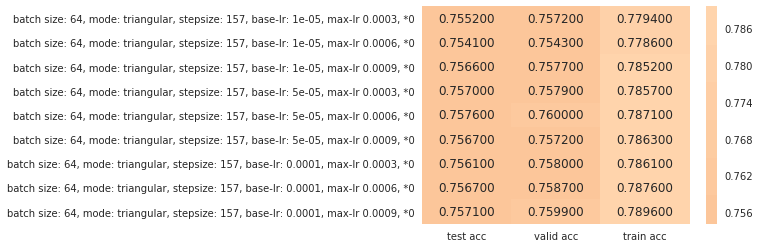

In [255]:
import seaborn as sns
sns.set()
heatmap = sns.heatmap(test.iloc[:3,:].transpose(), annot=True, center = 0, fmt = 'f')

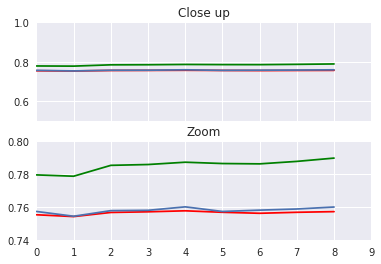

In [251]:
%matplotlib inline

# f, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row')
# ax1.plot(mean_test_acc, color = 'r')
# ax1.axis([0, 9, 0.5, 1])
# ax1.set_title('Test accuracies')
# ax2.plot(mean_valid_acc)
# ax2.axis([0, 9, 0.5, 1])
# ax2.set_title('Validation accuarcies')
# ax3.plot(mean_test_acc, color = 'r')
# ax3.axis([0, 9, 0.7, 0.8])
# ax4.plot(mean_valid_acc)
# ax4.axis([0, 9, 0.7, 0.8])
# ax5.plot(mean_train_acc, color = 'g')
# ax5.axis([0, 9, 0.5, 1])
# ax5.set_title('Training accuarcies')
# ax6.plot(mean_train_acc, color = 'g')
# ax6.axis([0, 9, 0.7, 0.8])

f, (ax1, ax2) = plt.subplots(2, 1, sharex='col', sharey='row')
ax1.plot(mean_test_acc, color = 'r')
ax1.axis([0, 9, 0.5, 1])
ax1.set_title('Close up')
ax1.plot(mean_valid_acc)
ax1.plot(mean_train_acc, color = 'g')
ax2.set_title('Zoom')
ax2.plot(mean_test_acc, color = 'r')
ax2.axis([0, 9, 0.74, 0.8])
ax2.plot(mean_valid_acc)
ax2.plot(mean_train_acc, color = 'g')

In [270]:
base_lr = 0.00001
max_lr = 0.0006
stepsizes128 = [157, 210, 262]
stepsizes64 = [315, 420,525]
batch_sizes = [64, 128]
modes = ['triangular', 'triangular2']
rep = 1

In [267]:
def hp_tuner(base_lr = base_lr, max_lr = max_lr, rep = 5):
    start_time = time()  
    global test_acc_l
    global valid_acc_l
    global train_acc_l
    global test_loss_l
    global valid_loss_l
    global train_loss_l
    global test_prec_l
    global valid_prec_l
    global train_prec_l
    global test_rec_l
    global valid_rec_l
    global train_rec_l
    global model_det
    model_det = []
    test_acc_l = []
    valid_acc_l = []
    train_acc_l = []
    test_loss_l = []
    valid_loss_l = []
    train_loss_l = []
    test_prec_l = []
    valid_prec_l = []
    train_prec_l = []
    test_rec_l = []
    valid_rec_l = []
    train_rec_l = []
    for bs in batch_sizes:
        if (bs == 64):
            stepsizes = stepsizes64
        if (bs ==128):
            stepsizes = stepsizes128
        for sz in stepsizes: 
            for md in modes:
                i = 0
                mid_time = time()
                while (i < rep):
                    compileModel()
                    times = i
                    if (i == 0):
                        train_Model(times = times, epochs = 48, base_lr = blr, max_lr = mlr, verbose = 0,
                                    batch_size = bs, stepsize = sz, mode = md, use_tensorboard = True)
                    else:
                        train_Model(times = times, epochs = 48, base_lr = blr, max_lr = mlr, verbose = 0, 
                                    batch_size = bs, stepsize = sz, mode = md, use_tensorboard = False)
                    valid_metrics = Final_model.evaluate(valid_images, valid_labels)
                    test_metrics = Final_model.evaluate(test_images, test_labels)
                    train_metrics = Final_model.evaluate(train_images, train_labels)
                    
                    train_acc = train_metrics[1]
                    valid_acc = valid_metrics[1]
                    test_acc = test_metrics[1]
                    train_loss = train_metrics[0]
                    valid_loss = valid_metrics[0]
                    test_loss = test_metrics[0]
                    train_prec = train_metrics[2]
                    valid_prec = valid_metrics[2]
                    test_prec = test_metrics[2]
                    train_rec = train_metrics[3]
                    valid_rec = valid_metrics[3]
                    test_rec = test_metrics[3]                                
                    test_acc_l.append(test_acc)
                    valid_acc_l.append(valid_acc)
                    train_acc_l.append(train_acc)
                    test_loss_l.append(test_loss)
                    valid_loss_l.append(valid_loss)
                    train_loss_l.append(train_loss)
                    test_prec_l.append(test_prec)
                    valid_prec_l.append(valid_prec)
                    train_prec_l.append(train_prec)
                    test_rec_l.append(test_rec)
                    valid_rec_l.append(valid_rec)
                    train_rec_l.append(train_rec)
                    model_det.append(name)
    ### training the same model for more epochs
                    if (i == 0):
                        train_Model(times = times, epochs = 48, base_lr = blr, max_lr = mlr, verbose = 0,
                                    batch_size = bs, stepsize = sz, mode = md, use_tensorboard = True)
                    else:
                        train_Model(times = times, epochs = 48, base_lr = blr, max_lr = mlr, verbose = 0, 
                                    batch_size = bs, stepsize = sz, mode = md, use_tensorboard = False)
                    valid_metrics = Final_model.evaluate(valid_images, valid_labels)
                    test_metrics = Final_model.evaluate(test_images, test_labels)
                    train_metrics = Final_model.evaluate(train_images, train_labels)
                    
                    train_acc = train_metrics[1]
                    valid_acc = valid_metrics[1]
                    test_acc = test_metrics[1]
                    train_loss = train_metrics[0]
                    valid_loss = valid_metrics[0]
                    test_loss = test_metrics[0]
                    train_prec = train_metrics[2]
                    valid_prec = valid_metrics[2]
                    test_prec = test_metrics[2]
                    train_rec = train_metrics[3]
                    valid_rec = valid_metrics[3]
                    test_rec = test_metrics[3]                                
                    test_acc_l.append(test_acc)
                    valid_acc_l.append(valid_acc)
                    train_acc_l.append(train_acc)
                    test_loss_l.append(test_loss)
                    valid_loss_l.append(valid_loss)
                    train_loss_l.append(train_loss)
                    test_prec_l.append(test_prec)
                    valid_prec_l.append(valid_prec)
                    train_prec_l.append(train_prec)
                    test_rec_l.append(test_rec)
                    valid_rec_l.append(valid_rec)
                    train_rec_l.append(train_rec)
                    name2 = name + '_x2'
                    model_det.append(name2)
                    print(log_dir)
                    i += 1
                mid_end_time = time()
                mid_time_dif = mid_end_time - mid_time
                print('Time usage: ' + str(timedelta(seconds=int(round(mid_time_dif)))) + ' minutes')
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')

In [341]:
hp_tuner(rep = 5)

 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.510050). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:21 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:48 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.501570). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:07 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:48 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.530211). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:09 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:51 minutes
3357/3357 [==============================] - 5s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.529254). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:15 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.494157). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:05 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:47 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:30:57 minutes
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.607361). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:09 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:43 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.579401). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:07 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:41 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.575486). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:08 minutes
3357/3357 [==============================] - 5s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:46 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.553521). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:05 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:44 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.544658). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:07 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 315, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:30:15 minutes
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.479330). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:12 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:49 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.469325). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:01 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:50 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.541773). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:10 minutes
3357/3357 [==============================] - 5s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:53 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.461620). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:03 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.447579). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:06 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:44 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:30:33 minutes
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.517968). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:09 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.499047). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:04 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:47 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.534061). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:10 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:47 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.474570). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:04 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:43 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.454189). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:03 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 420, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:43 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:30:15 minutes
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.454632). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:09 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.448387). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:04 minutes
3357/3357 [==============================] - 5s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:46 minutes
3357/3357 [==============================] - 5s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.478908). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:04 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:49 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.491129). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:06 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:43 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.450104). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:01 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:30:12 minutes
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.487115). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:08 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:43 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.437819). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:06 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.441234). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:05 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.428104). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:01 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:42 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.439236). Check your callbacks.
  % delta_t_median)


Time usage: 0:03:03 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 64, mode: triangular2, stepsize: 525, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:43 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:29:59 minutes
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.447502). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:41 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:17 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.432487). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:36 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:18 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.443496). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:36 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:17 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.451763). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:36 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:18 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.437585). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:35 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:18 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:25:31 minutes
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.442458). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:43 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:19 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.443079). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:37 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:17 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.448603). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:37 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:18 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.454756). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:37 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:18 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.448371). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:40 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 157, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:19 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:25:43 minutes
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.466672). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:19 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.453376). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:38 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:17 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.454743). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:38 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:17 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.458397). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:40 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:21 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.459882). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:41 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:22 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:25:58 minutes
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.457304). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:48 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:21 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.447801). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:41 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:19 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.486629). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:39 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:18 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.468673). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:39 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:19 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.486300). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:42 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 210, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:21 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:26:07 minutes
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.503637). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:49 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:23 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.536921). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:43 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:21 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.494913). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:43 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:21 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.510180). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:42 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:21 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.489815). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:41 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:22 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:26:26 minutes
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *0


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.485529). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:50 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *0
Time usage: 0:02:23 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *1


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.510402). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:44 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *1
Time usage: 0:02:21 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *2


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.496126). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:42 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *2
Time usage: 0:02:26 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *3


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.510509). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:41 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *3
Time usage: 0:02:21 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *4


/home/rick/.conda/envs/hannah_z/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.513950). Check your callbacks.
  % delta_t_median)


Time usage: 0:02:45 minutes
3357/3357 [==============================] - 4s 1ms/step
 - Model specifics:	batch size: 128, mode: triangular2, stepsize: 262, base-lr: 0.0001, max-lr 0.0009, *4
Time usage: 0:02:23 minutes
3357/3357 [==============================] - 4s 1ms/step
/home/rick/Documents/HannahZ/Code/logs
Time usage: 0:26:37 minutes
Time usage: 5:38:31 minutes


In [360]:
rep = 5
titel = model_details[0][:47]
mean_test_a = []
mean_valid_a = []
mean_train_a = []
mean_test_l = []
mean_valid_l = []
mean_train_l = []
mean_test_p = []
mean_valid_p = []
mean_train_p = []
mean_test_r = []
mean_valid_r = []
mean_train_r = []
model_l = []
a = int(len(test_acc_l)/rep)
for i in range(a):
    tals = test_acc_l[i:(i+1)*rep]
    vals = valid_acc_l[i:(i+1)*rep]
    rals = train_acc_l[i:(i+1)*rep]
    tlls = test_loss_l[i:(i+1)*rep]
    vlls = valid_loss_l[i:(i+1)*rep]
    rlls = train_loss_l[i:(i+1)*rep]
    tpls = test_prec_l[i:(i+1)*rep]
    vpls = valid_prec_l[i:(i+1)*rep]
    rpls = train_prec_l[i:(i+1)*rep]
    trls = test_rec_l[i:(i+1)*rep]
    vrls = valid_rec_l[i:(i+1)*rep]
    rrls = train_rec_l[i:(i+1)*rep]
    tmean = round(sum(tals)/len(tals),4)
    vmean = round(sum(vals)/len(vals),4)
    rmean = round(sum(rals)/len(rals),4)
    ltmean = round(sum(tlls)/len(tals),4)
    lvmean = round(sum(vlls)/len(vals),4)
    lrmean = round(sum(rlls)/len(rals),4)
    ptmean = round(sum(tpls)/len(tals),4)
    pvmean = round(sum(vpls)/len(vals),4)
    prmean = round(sum(rpls)/len(rals),4)
    rtmean = round(sum(trls)/len(tals),4)
    rvmean = round(sum(vrls)/len(vals),4)
    rrmean = round(sum(rrls)/len(rals),4)
    mean_test_a.append(tmean)
    mean_valid_a.append(vmean)
    mean_train_a.append(rmean)
    mean_test_l.append(ltmean)
    mean_valid_l.append(lvmean)
    mean_train_l.append(lrmean)
    mean_test_p.append(ptmean)
    mean_valid_p.append(pvmean)
    mean_train_p.append(prmean)
    mean_test_r.append(rtmean)
    mean_valid_r.append(rvmean)
    mean_train_r.append(rrmean)
    if (model_det[i*rep][-2:] == 'x2'):
        model_l.append(model_det[i*rep][6:49] + ' ' + model_det[i*rep][-2:])
    else:
        model_l.append(model_det[i*rep][6:49])

In [361]:
print(model_det[8][6:49])
print(model_det[0][-2:])

size: 64, mode: triangular, stepsize: 315, 
*0


In [362]:
cols = ['test acc', 'valid acc', 'train acc', 'test loss', 'valid loss', 'train loss', 'test prec', \
           'valid prec', 'train prec', 'test rec', 'valid rec', 'train rec']
data2 = np.array((mean_test_a, mean_valid_a, mean_train_a, mean_test_l, mean_valid_l, mean_train_l,\
                mean_test_p, mean_valid_p, mean_train_p, mean_test_r, mean_valid_r, mean_train_r))
results2 = pd.DataFrame(data = data2, columns = model_l, index = cols)
hp_overview = pd.DataFrame(data = results2.transpose(), columns = cols, index = model_l)
#hp_overview
hp_overview.sort_values(by=['test acc'], ascending = False)

,test acc,valid acc,train acc,test loss,valid loss,train loss,test prec,valid prec,train prec,test rec,valid rec,train rec
"size: 64, mode: triangular, stepsize: 315,",0.7420,0.7380,0.7743,2.3157,2.4599,1.9065,0.6758,0.6528,0.6971,0.9551,0.9637,0.9689
"size: 128, mode: triangular2, stepsize: 262 x2",0.7416,0.7410,0.7797,2.1874,2.2810,1.7320,0.6780,0.6565,0.7046,0.9515,0.9624,0.9655
"size: 128, mode: triangular2, stepsize: 262",0.7414,0.7408,0.7793,2.1972,2.2884,1.7419,0.6777,0.6562,0.7041,0.9521,0.9630,0.9660
"size: 64, mode: triangular, stepsize: 420,",0.7411,0.7398,0.7785,2.2117,2.2893,1.7433,0.6741,0.6535,0.7008,0.9599,0.9653,0.9708
"size: 128, mode: triangular, stepsize: 262, x2",0.7409,0.7402,0.7788,2.2109,2.3038,1.7545,0.6771,0.6557,0.7035,0.9525,0.9631,0.9663
"size: 128, mode: triangular2, stepsize: 210 x2",0.7409,0.7398,0.7784,2.2038,2.2952,1.7450,0.6754,0.6543,0.7016,0.9566,0.9656,0.9687
"size: 128, mode: triangular, stepsize: 210,",0.7409,0.7401,0.7791,2.2046,2.2941,1.7418,0.6752,0.6547,0.7023,0.9572,0.9650,0.9691
"size: 128, mode: triangular2, stepsize: 210",0.7408,0.7394,0.7785,2.2072,2.3001,1.7473,0.6753,0.6540,0.7016,0.9568,0.9652,0.9690
"size: 128, mode: triangular, stepsize: 210, x2",0.7408,0.7396,0.7790,2.2152,2.3071,1.7513,0.6753,0.6543,0.7022,0.9565,0.9648,0.9689
"size: 64, mode: triangular2, stepsize: 315, x2",0.7401,0.7394,0.7789,2.1848,2.2746,1.7250,0.6738,0.6531,0.7011,0.9578,0.9651,0.9707


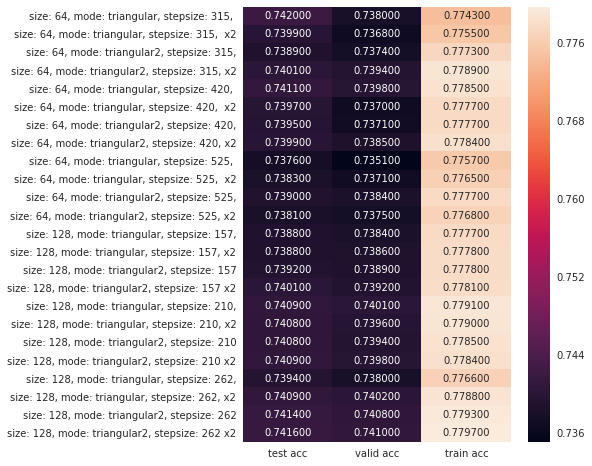

In [365]:
%matplotlib inline
plt.figure(figsize=(6, 8))

sns.heatmap(hp_overview.iloc[:,:3], annot=True,  fmt = 'f')

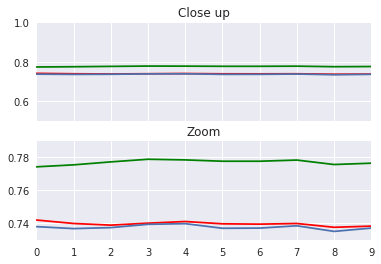

In [368]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(2, 1, sharex='col', sharey='row')
ax1.plot(mean_test_a, color = 'r')
ax1.axis([0, 9, 0.5, 1])
ax1.set_title('Close up')
ax1.plot(mean_valid_a)
ax1.plot(mean_train_a, color = 'g')
ax2.set_title('Zoom')
ax2.plot(mean_test_a, color = 'r')
ax2.axis([0, 9, 0.73, 0.79])
ax2.plot(mean_valid_a)
ax2.plot(mean_train_a, color = 'g')

In [373]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
hp_overview.sort_values(by=['test acc'], ascending = False).iloc[:3,:]
# hp_overview.sort_values(by=['test loss'], ascending = True).iloc[:3,:]
# hp_overview.sort_values(by=['test prec'], ascending = False).iloc[:3,:]
# hp_overview.sort_values(by=['test rec'], ascending = False).iloc[:3,:]
model_det[0][49:79]

NameError: name 'hp_overview' is not defined

In [396]:
name = ('bs-' + str(batch_size) + '_' + str(mode) + '_sz-' + str(stepsize) + '_blr-' + str(base_lr) + '_mlr-' 
        + str(max_lr)) + '_' + weights + '_' + trainable_layers
model_dir + '/' + name + '.hdf5'

'/home/rick/Documents/HannahZ/Code/Final_models/bs-64_triangular_sz-157_blr-1e-05_mlr-0.0009_imagenet_Frozen.hdf5'

In [18]:
# decide on best hyperparameters
batch_size = 64
step_size = 315
mode = 'triangular'
base_lr = 0.00001
max_lr = 0.0009
epochs = 48
d3 = {}

In [19]:
def trainModels(batch_size = batch_size, stepsize = step_size, mode = mode, max_lr = max_lr, base_lr = base_lr, 
                epochs = epochs, verbose = 0):
    start_time = time()   
    global name
    global filepath
    global d    
    date = str(datetime.now().date())
    d = {}
    for i in range(5):
        compileModel()
        # logdir in linux:
        logdir = (log_dir + '/' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) 
                  + '_base-' + str(base_lr) + '_max-' + str(max_lr) + '_' + str(i))
        # logdir in windows:
        ##logdir = (log_dir + '\\' + date + '_' + str(batch_size) + '_' + str(mode) + '_si-' + str(stepsize) + 
        #          '_base-' + str(base_lr) + '_max-' + str(max_lr) + '_' + str(i))
        name = ('batch size: ' + str(batch_size) + ', mode: ' + str(mode) + ', stepsize: ' 
                + str(stepsize) + ', base-lr: ' + str(base_lr) + ', max-lr ' + str(max_lr) + '_' + str(i))
        print(' - Model specifics:\t{}'.format(name))
        clr = CyclicLR(base_lr = base_lr, max_lr=max_lr, step_size= stepsize, mode = mode)
        fp = (str(modelname) + '_bs-' + str(batch_size) + '_' + str(mode) + '_sz-' + str(step_size) + '_blr-' 
              + str(base_lr) + '_mlr-' + str(max_lr) + '_e-' + str(epochs) + '_' + weights + '_' 
              + str(trainable_layers) + '_' + str(i))
        filepath = new_weight_dir + '/' + fp + '-{epoch:02d}-' +'.hdf5'
        checkp = ModelCheckpoint(filepath, monitor='val_acc', verbose= verbose, save_weights_only=True, 
                                save_best_only=True, mode='max', period=1)
        tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, 
                             write_graph=False, write_images=False)
        d["FinalModel{0}".format(i)]= Final_model
        d["FinalModel{0}".format(i)].fit(x = train_images, y = train_labels, epochs = epochs, 
                                         callbacks= [tbCallBack, clr, checkp], batch_size = batch_size,
                                         validation_data = (valid_images, valid_labels), verbose = 0)
    end_time = time()
    time_dif = end_time - start_time
    print('Time usage: ' + str(timedelta(seconds=int(round(time_dif)))) + ' minutes')

In [20]:
# build best model again
# usual time: 15 minutes - 18 - 15 - 13
fm = ['FinalModel1', 'FinalModel2', 'FinalModel3', 'FinalModel4', 'FinalModel5']
metrics = ['loss', 'acc', 'precision', 'recall']
name = ('bs-' + str(batch_size) + '_' + str(mode) + '_sz-' + str(step_size) + '_blr-' + str(base_lr) + '_mlr-' 
       + str(max_lr)) + '_' + str(weights) + '_' + str(trainable_layers)
trainModels(base_lr = base_lr, max_lr= max_lr, epochs = epochs, verbose = 0,
           batch_size = batch_size, stepsize = step_size, mode = mode)

 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0009_0
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0009_1
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0009_2
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0009_3
 - Model specifics:	batch size: 64, mode: triangular, stepsize: 315, base-lr: 1e-05, max-lr 0.0009_4
Time usage: 0:13:20 minutes


In [22]:
# find out where 'bs' starts and '_' ends...
i = 0
last = 124
print(str(filepath)[46:last] + str(i) + str(filepath)[(last+1):])
filename = str(filepath)[46:last] + str(i)
print(filename)
from collections import OrderedDict

DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_0-{epoch:02d}-.hdf5
DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_0


In [23]:
# usual time: 2 minutes
startTime = time()
FinalModelList = OrderedDict()
d3 = OrderedDict()
for i in range(5):
    filename = str(filepath)[46:last] + str(i) #+ str(filepath)[113:]
    weightlist = os.listdir(new_weight_dir)
    print(filename)
    best_filename = 'no'
    for el in weightlist:
        if(str(el)[:len(filename)]) == filename:
            if len(el)>(len(filename)+5):
                best_filename = el
    print(best_filename)
    best = str(best_filename)[-8:-6]
    os.chdir(new_weight_dir)
    compileModel()
    Final_model.load_weights(best_filename)
    FinalModelList["FinalModel{}-e{}".format(i,best)]= Final_model
    test_m = Final_model.evaluate(test_images, test_labels, verbose = 0)
    test_m = [round(el, 4) for el in test_m]
    valid_m = Final_model.evaluate(valid_images, valid_labels, verbose = 0)
    valid_m = [round(el, 4) for el in valid_m]
    train_m = Final_model.evaluate(train_images, train_labels, verbose = 0)
    train_m = [round(el, 4) for el in train_m]
    col = ["FinalModel{}-e{}".format(i,best)]
    print("td{}-e{}".format(i, best))
    d3["td{}-e{}".format(i, best)]= pd.DataFrame(data = test_m[:4], columns = col, index = metrics)
    print('')
endTime = time()
finalTime = endTime - startTime
print('Time usage: ' + str(timedelta(seconds=int(round(finalTime)))) + ' minutes')

DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_0
DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_0-20-.hdf5
td0-e20

DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_1
DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_1-08-.hdf5
td1-e08

DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_2
DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_2-15-.hdf5
td2-e15

DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_3
DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_3-04-.hdf5
td3-e04

DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_4
DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_4-07-.hdf5
td4-e07

Time usage: 0:00:53 minutes


In [24]:
keys = d3.keys()
FinalResults = pd.concat([d3[keys[0]], d3[keys[1]], d3[keys[2]], d3[keys[3]], d3[keys[4]]], axis=1)
FinalResults = pd.DataFrame(data = FinalResults.transpose(), columns = metrics)
FinalResults.sort_values(by = ['acc'], ascending = False)

,loss,acc,precision,recall
FinalModel3-e04,0.5843,0.8009,0.7869,0.8436
FinalModel1-e08,0.6962,0.7998,0.8140,0.7981
FinalModel0-e20,1.1354,0.7816,0.7436,0.8758
FinalModel2-e15,1.0915,0.7805,0.7235,0.9349
FinalModel4-e07,0.8400,0.7794,0.7254,0.9203


In [25]:
dictlist = FinalModelList.keys()
print(dictlist)
models = [FinalModelList[dictlist[0]], FinalModelList[dictlist[1]], FinalModelList[dictlist[2]], \
          FinalModelList[dictlist[3]], FinalModelList[dictlist[4]]]
def ensemble(models):    
    global eModel
    outputs = [model.outputs[0] for model in models]
    y = keras.layers.Average()(outputs)   
    eModel = Model(inputs=Model_base.input, outputs = y, name='ensemble')  
    eModel.compile(optimizer='rmsprop', loss='binary_crossentropy',
                   metrics=['accuracy', precision, recall, fmeasure])
    return eModel
ensemble_model = ensemble(models)
ensResults = ensemble_model.evaluate(test_images, test_labels)
Res = pd.DataFrame(data = ensResults[:4], columns = ['ensembleModel'], index = metrics)
Res.transpose()
keys = d3.keys()
FinalResults = pd.concat([d3[keys[0]], d3[keys[1]], d3[keys[2]], d3[keys[3]], d3[keys[4]], Res], axis=1)
FinalResults = pd.DataFrame(data = FinalResults.transpose(), columns = metrics)
FinalResults.sort_values(by = ['acc'], ascending = False)

['FinalModel0-e20', 'FinalModel1-e08', 'FinalModel2-e15', 'FinalModel3-e04', 'FinalModel4-e07']
934/934 [==============================] - 4s 4ms/step


,loss,acc,precision,recall
FinalModel3-e04,0.584300,0.800900,0.786900,0.843600
FinalModel1-e08,0.696200,0.799800,0.814000,0.798100
ensembleModel,0.560071,0.788009,0.752668,0.881524
FinalModel0-e20,1.135400,0.781600,0.743600,0.875800
FinalModel2-e15,1.091500,0.780500,0.723500,0.934900
FinalModel4-e07,0.840000,0.779400,0.725400,0.920300


In [27]:
# change again the path name
# saving the model   
i = 3
#FinName = str(filepath)[46:112] + '_ensemble' 
FinName = str(filepath)[46:last] + str(i) + dictlist[i][-4:]
print(FinName)
os.chdir(model_dir)
#Final_model1 = ensemble_model # or
Final_model = FinalModelList[dictlist[i]]
# predictions = np.round(Final_model.predict(test_images),4)           
# predictions_ensemble = np.round(Final_model1.predict(test_images),4)
# for v1, v2 in zip(predictions[:5], predictions_ensemble[:5]):
#     print('Best model prediction and ensemble prediction: \t{} \t{}'.format(v1, v2))

DenseNet121_bs-64_triangular_sz-315_blr-1e-05_mlr-0.0009_e-48_imagenet_Frozen_3-e04


In [28]:
Final_model.save(FinName)

In [ ]:
# calculating the ROC    
y_pred = Final_model.predict(test_images, batch_size = 64)
y_true = test_labels
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='lime',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# calculating the ROC    
y_pred = Final_model.predict(test_images, batch_size = 64)
y_true = test_labels
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='lime',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# evaluation with bootstrapping
seed(1)
ratio = 0.1
y_pred_1 = Final_model.predict(test_images, batch_size = 64).squeeze(axis = 1)
def subsample(dataset = y_pred_1, labels = test_labels, ratio= ratio):
    pred_sample = list()
    label_sample = list()
    n_sample = round(len(dataset) * ratio)
    index = sample(range(len(dataset)), n_sample)
    pred_sample = dataset[index]
    label_sample = labels[index]           
    return pred_sample, label_sample

loss = []
accuracy = []
precisions = []
recalls = []
f_measures = []
    
def bootstrap(iterations = 20, ratio = ratio, dataset = y_pred_1, labels = test_labels):    
    for i in range (iterations):
        b_pred, b_labels = subsample(dataset, labels, ratio)
        lo = cross_entropy(b_pred, b_labels)
        b_pred_rounded = b_pred.round()
        acc = accuracy_score(b_labels, b_pred_rounded)
        pre = precision_score(b_labels, b_pred_rounded)
        rec = recall_score(b_labels, b_pred_rounded)
        fme = f1_score(b_labels, b_pred_rounded)
        loss.append(lo)
        accuracy.append(acc)
        precisions.append(pre)
        recalls.append(rec)
        f_measures.append(fme)
        if (i%100 == 0): 
            print('Iteration_' + str(i))
        
bootstrap(iterations = 10000)
plt.hist(accuracy, bins = 100, range = [0,1])
plt.hist(precisions, bins = 100, range = [0,1])
plt.hist(recalls, bins = 100, range = [0,1])
plt.hist(loss, bins = 100)

##################### second training stage ###################################
for i, layer in enumerate(Model_base.layers):
   if ('mix' in layer.name):
       print(i, layer.name)
for layer in Final_model.layers[:275]:
   layer.trainable = False
for layer in Final_model.layers[275:]:
   layer.trainable = True

Final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='binary_crossentropy', metrics = ['acc'])
def train2_IncResNet_model(epochs = 21):
    global no_of_epochs
    Final_model.fit(x = train_images, y = train_labels, epochs = epochs)
    no_of_epochs = no_of_epochs + epochs
train2_IncResNet_model(epochs = 21)

result = Final_model.evaluate(test_images, test_labels)
for name, value in zip(Final_model.metrics_names, result):
    print(name, value)

### making predictions on the test data
predictions = Final_model.predict(test_images).squeeze(axis = 1)
binary_preds = predictions.round()
print(predictions[0:10], binary_preds[0:10])

# Plot a few images to see if the data is correct
images = test_images[9:18]
cls_true = test_labels[9:18].astype(int)
plot_images(images=images, cls_true=cls_true)
cls_pred = binary_preds[9:18]
plot_images(images=images, cls_true=cls_true, cls_pred = cls_pred)    

### checking test accuracy, example errors and confusion matrix
print_test_accuracy

### checking which layers are convolutional layers
for i, layer in enumerate(Model_base.layers):
   if ('conv' in layer.name):
       print(i, layer.name)

plot_weights(input_channel = 0, layer_index = 1)
plot_weights(input_channel = 1, layer_index = 1)


















#*****************************************************************************
################# HELPER FUNCTIONS ###########################################
#
#*****************************************************************************

### Helper function for confusion matrix #####################################
import itertools
classes = ['no sp', 'sp']

def plot_confusion_matrix(cm = cm, classes = classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum()
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")     
    plt.tight_layout(pad = 2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


###### Helper function for plotting images ####################################
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='binary')
        if cls_pred is None:
            xlabel = "Label: {0}".format(cls_true[i])
        else:
            xlabel = "Label: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() 
    
### Example errors
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = test_images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = test_labels[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def print_test_accuracy(show_example_errors=True,
                        show_confusion_matrix=True, 
                        show_first_10_preds = True):
    num_test = len(test_images)
    #cls_pred = np.zeros(shape=num_test, dtype=np.int)
    cls_pred = Final_model.predict(test_images).squeeze(axis = 1).round()
    cls_true = test_labels
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        cm = confusion_matrix(test_labels, cls_pred.round())
        plot_confusion_matrix(cm = cm)
    # Show the first hundred predictions made:
    if show_first_10_preds:
        print("First 10 predictions:")
        print(cls_pred[0:10])


#### Helper function for plotting the output of a convolutional layer
#def plot_conv_layer(layer, image):
#    feed_dict = {x: [image]}
#    values = IncResNet_model.run(layer, feed_dict=feed_dict)
#    num_filters = values.shape[3]
#    num_grids = math.ceil(math.sqrt(num_filters))
#    fig, axes = plt.subplots(num_grids, num_grids)
#    for i, ax in enumerate(axes.flat):
#        if i<num_filters:
#            img = values[0, :, :, i]
#            ax.imshow(img, interpolation='nearest', cmap='binary')
#        ax.set_xticks([])
#        ax.set_yticks([])
#    plt.show()

### Helper function for conv weights
def plot_weights(input_channel=0, layer_index = 1):
    w = Final_model.layers[layer_index].get_weights()[0]
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()